# Baysian Two-way Fixed Effects

- 階層ベイズモデル 不均一分散
- 階層ベイズモデル 均一分散
- 階層ベイズモデル 不均一分散 加重最小2乗法
- GLMM 不均一分散
- GLM 均一分散

In [34]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')
figsize = (10, 5)

In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

# 欠損値を削除
df = df.dropna(subset=['population'])

In [94]:
# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年をカテゴリ化
df.year = df.year.astype(str)
df.year = df.year.map(str.strip)
year, mn_years = df.year.factorize()

## サンプリングのインポート

In [87]:
trace_homo = az.from_netcdf('./mcmc_sample/twfe/trace_h_homo_kokucho_20250109.nc')

## TWFE

$$
\log{Y^*_{it}} = \log{Y_{it}} - \bar{\log{{Y}_{i}}}
$$

$$
\begin{aligned}
\log{Y^*_{it}} &\sim \mathcal{t}(\nu, \mu_{it}, \sigma^2) \\
\mu_{it} &= \beta \cdot T_{it} \\
\beta &\sim \mathcal{N}(0, 1) \\
\nu &\sim \mathcal{Exponential}(\lambda = 1/10) \\
\sigma &\sim \mathcal{Cauchy}^+(\beta=1) \\
\end{aligned}
$$

## 階層ベイズモデル 不均一分散

In [55]:
# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
COORDS = {'y': df.index, 'X': df.index, 'island_id': mn_island_ids, 'year': year_dummies.columns}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    island_ids = pm.Data('island_ids', island_ids, dims='X')
    treatment = pm.Data('treatment', df['after_treatment'], dims='X')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')

    sigma_global = pm.HalfCauchy('sigma_global', beta=1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_global, dims='island_id')

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = beta * treatment + island_effect[island_ids] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=log_pop)

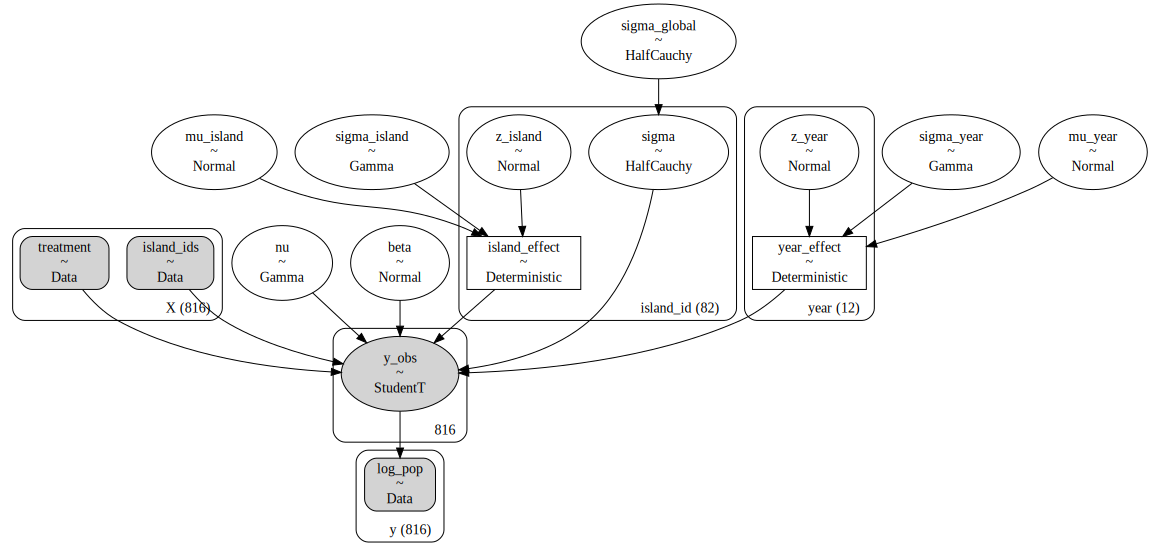

In [56]:
pm.model_to_graphviz(model_h_hetero)

In [57]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [58]:
az.to_netcdf(trace_h_hetero, '../../data/processed/trace_h_hetero_kokucho_20250109.nc')

'../../data/processed/trace_h_hetero_kokucho_20250109.nc'

In [60]:
az.summary(trace_h_hetero, var_names=['beta', 'nu', 'sigma_global', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year'], hdi_prob=.95)

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta           0.117   0.028     0.064      0.173      0.000    0.000   
nu            31.076  14.982     8.736     60.997      0.191    0.135   
sigma_global   0.181   0.025     0.135      0.232      0.000    0.000   
mu_island      6.284   0.243     5.801      6.754      0.016    0.011   
sigma_island   2.010   0.167     1.712      2.346      0.008    0.005   
mu_year       -0.504   0.186    -0.855     -0.125      0.005    0.003   
sigma_year     0.508   0.132     0.285      0.762      0.003    0.002   

              ess_bulk  ess_tail  r_hat  
beta            4527.0    5148.0   1.00  
nu              5444.0    4639.0   1.00  
sigma_global    9161.0    5840.0   1.00  
mu_island        226.0     518.0   1.01  
sigma_island     462.0     968.0   1.01  
mu_year         1537.0    2900.0   1.00  
sigma_year      2030.0    3253.0   1.00

In [67]:
beta_log = az.summary(trace_h_hetero, var_names=['beta'], hdi_prob=.95, round_to=5)['mean'].values
np.exp(beta_log) - 1

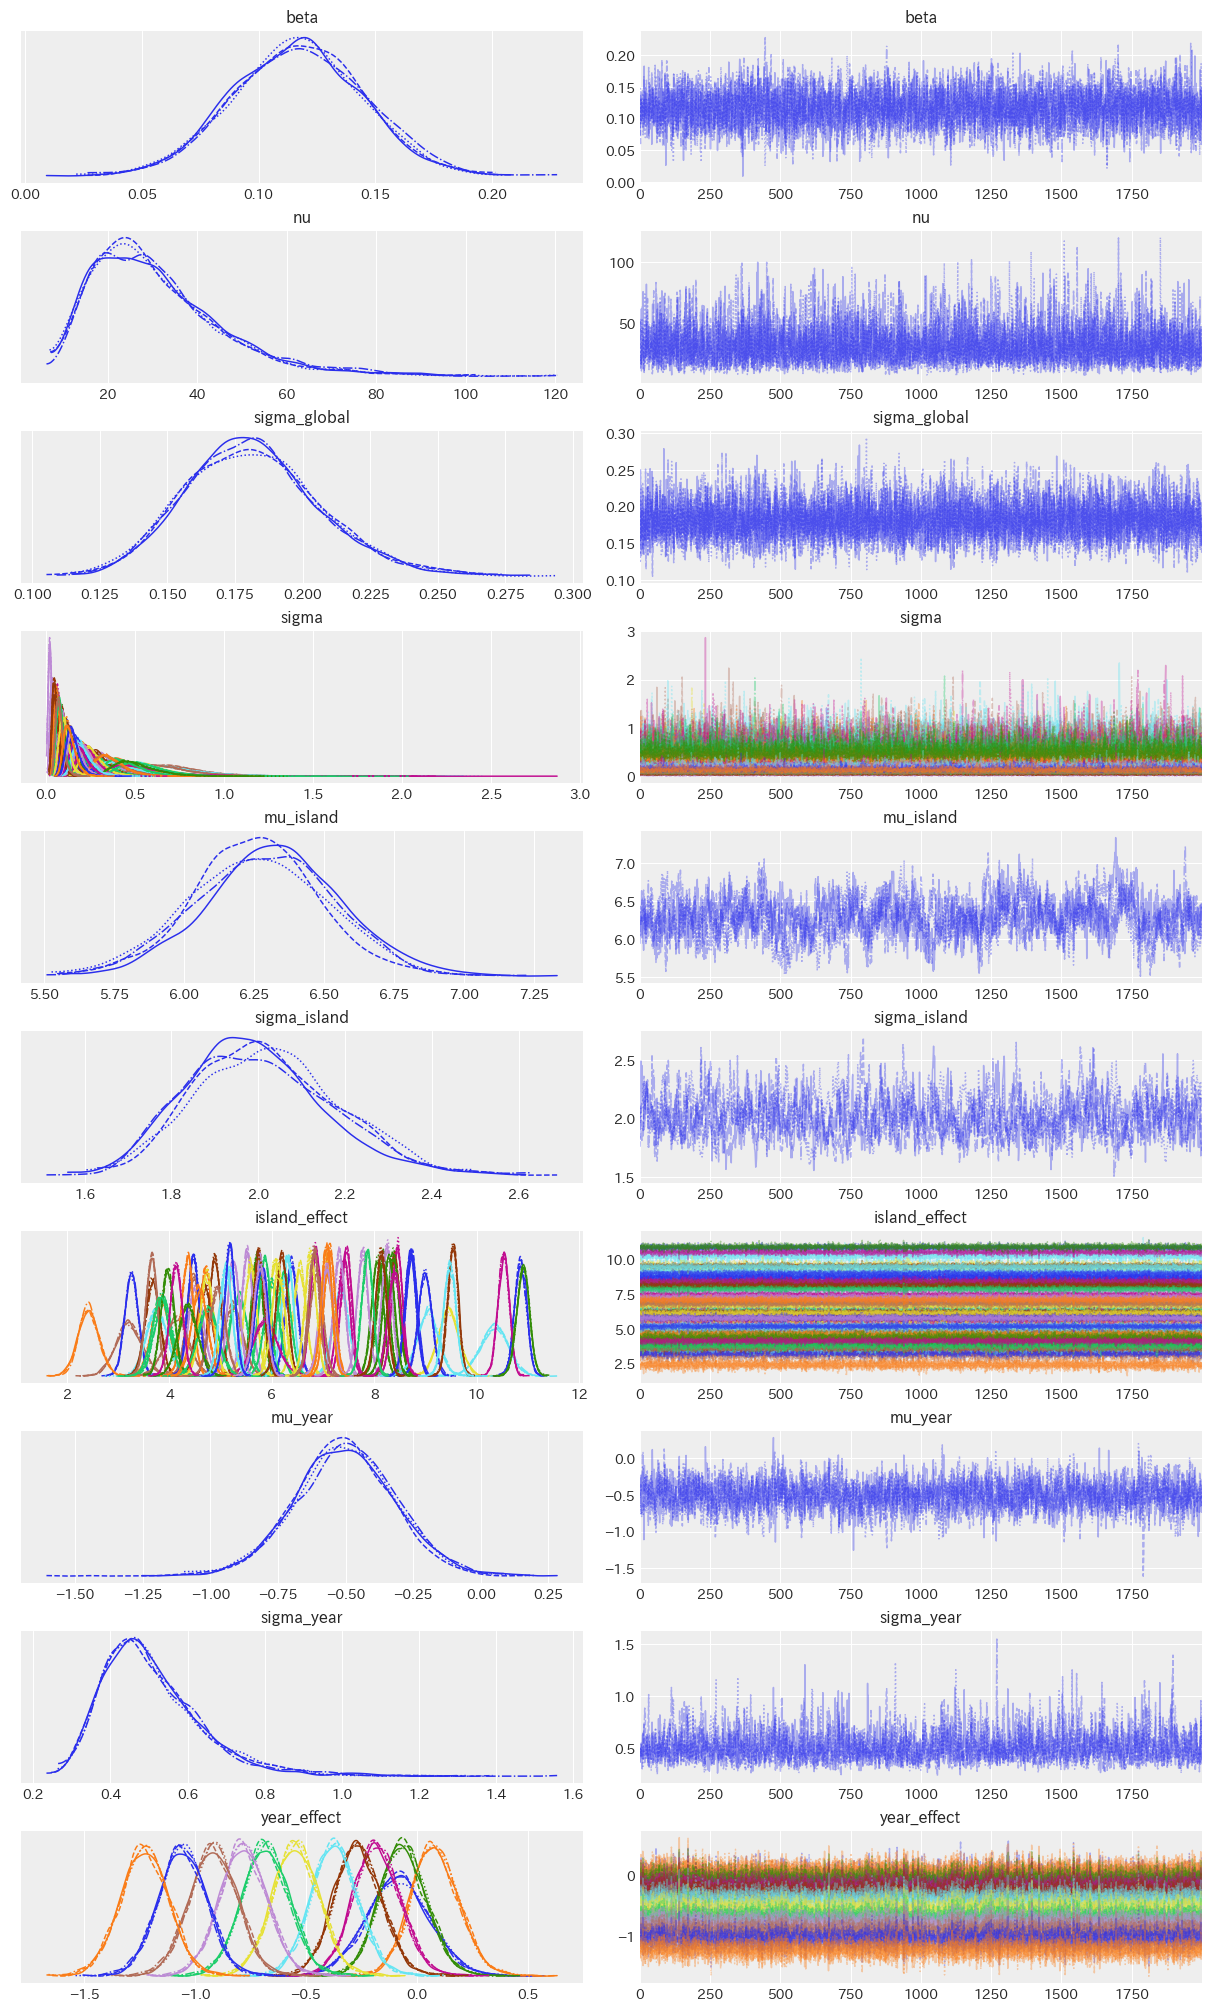

In [62]:
az.plot_trace(trace_h_hetero, var_names=['beta', 'nu', 'sigma_global', 'sigma', 'mu_island', 'sigma_island', 'island_effect', 'mu_year', 'sigma_year', 'year_effect']);

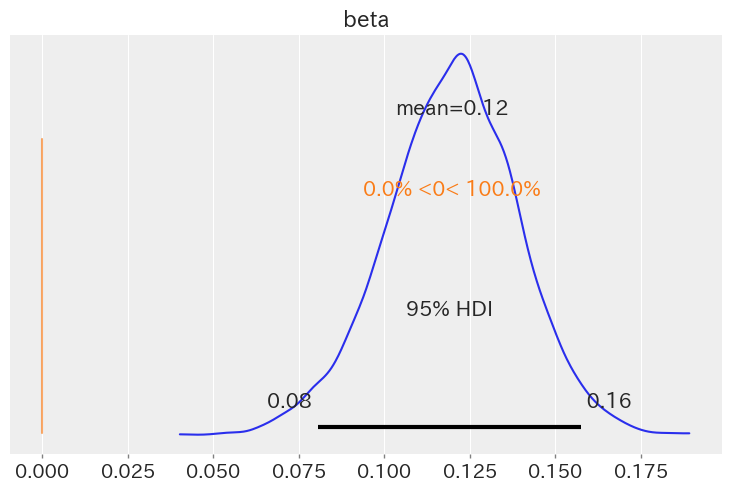

In [52]:
az.plot_posterior(trace_h_hetero, var_names=['beta'], ref_val=0, hdi_prob=.95);

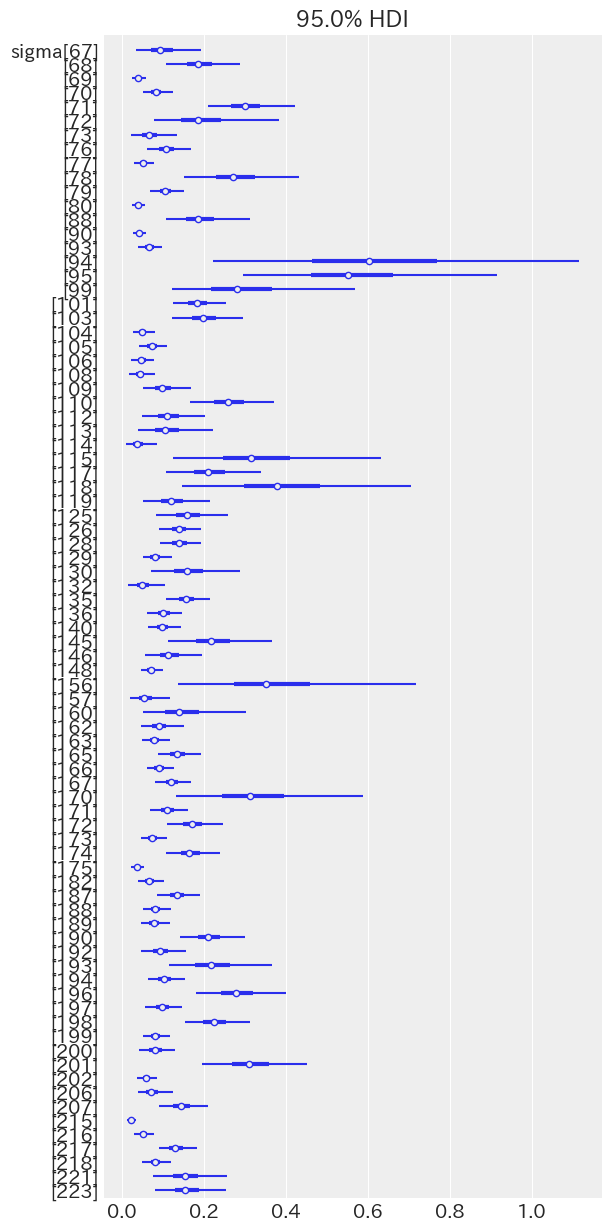

In [53]:
az.plot_forest(trace_h_hetero, var_names=['sigma'], combined=True, hdi_prob=.95);

In [71]:
with model_h_hetero:
    pm.compute_log_likelihood(trace_h_hetero)
az.waic(trace_h_hetero)

Output()

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 816 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   117.24    27.66
p_waic      158.28        -

There has been a warning during the calculation. Please check the results.

## 階層ベイズモデル 均一分散

In [60]:
# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年をカテゴリ化
# df.year = df.year.astype(str)
# df.year = df.year.map(str.strip)
# year, mn_years = df.year.factorize()
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)

COORDS = {'y': df.index, 'X': df.index, 'island_id': mn_island_ids, 'year': year_dummies.columns}

with pm.Model(coords=COORDS) as model_h_homo:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    island_ids = pm.Data('island_ids', island_ids, dims='X')
    treatment = pm.Data('treatment', df['after_treatment'], dims='X')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=6, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    # mu_year = pm.Normal('mu_year', mu=-0.997, sigma=1)
    # sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    # z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    # year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')
    year_effect = pm.Normal('year_effect', mu=-1, sigma=1, dims='year')

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)
    sigma = pm.HalfCauchy('sigma', beta=1)

    # expectation
    mu = beta * treatment + island_effect[island_ids] + pm.math.dot(year_dummies, year_effect)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop)

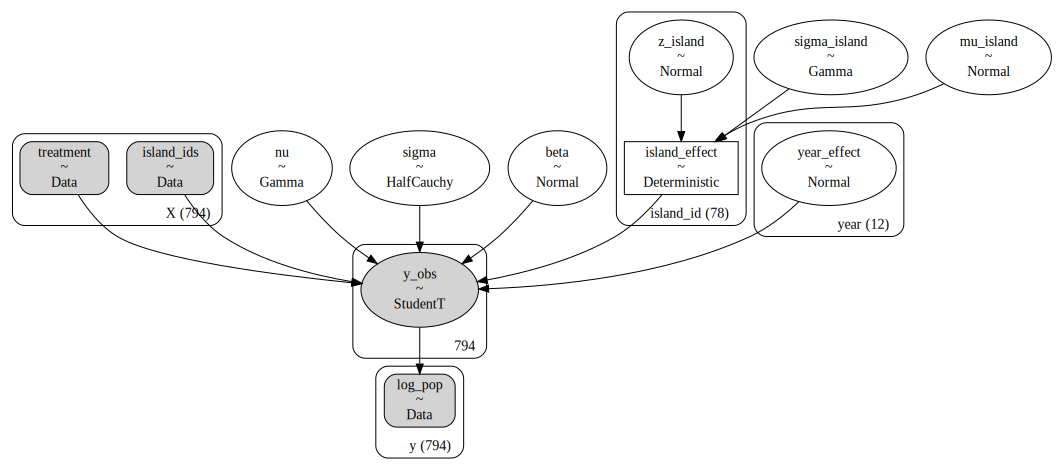

In [61]:
pm.model_to_graphviz(model_h_homo)

In [62]:
with model_h_homo:
    trace_homo = pm.sample(
        draws=3000,
        tune=3000,
        chains=4,
        cores=4,
        target_accept=.99,
        nuts_sampler='numpyro'
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [31]:
az.to_netcdf(trace_homo, './mcmc_sample/twfe/homo_20250112.nc')

'./mcmc_sample/twfe/homo_20250112.nc'

In [64]:
az.summary(trace_homo, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island', ])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta          0.214  0.030   0.156    0.270      0.001    0.000    2101.0   
sigma         0.143  0.009   0.127    0.160      0.000    0.000    1679.0   
nu            2.240  0.272   1.754    2.747      0.006    0.004    1883.0   
mu_island     6.403  0.264   5.906    6.870      0.019    0.013     202.0   
sigma_island  1.975  0.157   1.685    2.266      0.009    0.007     292.0   

              ess_tail  r_hat  
beta            3463.0   1.00  
sigma           2649.0   1.00  
nu              3201.0   1.00  
mu_island        448.0   1.01  
sigma_island     315.0   1.01

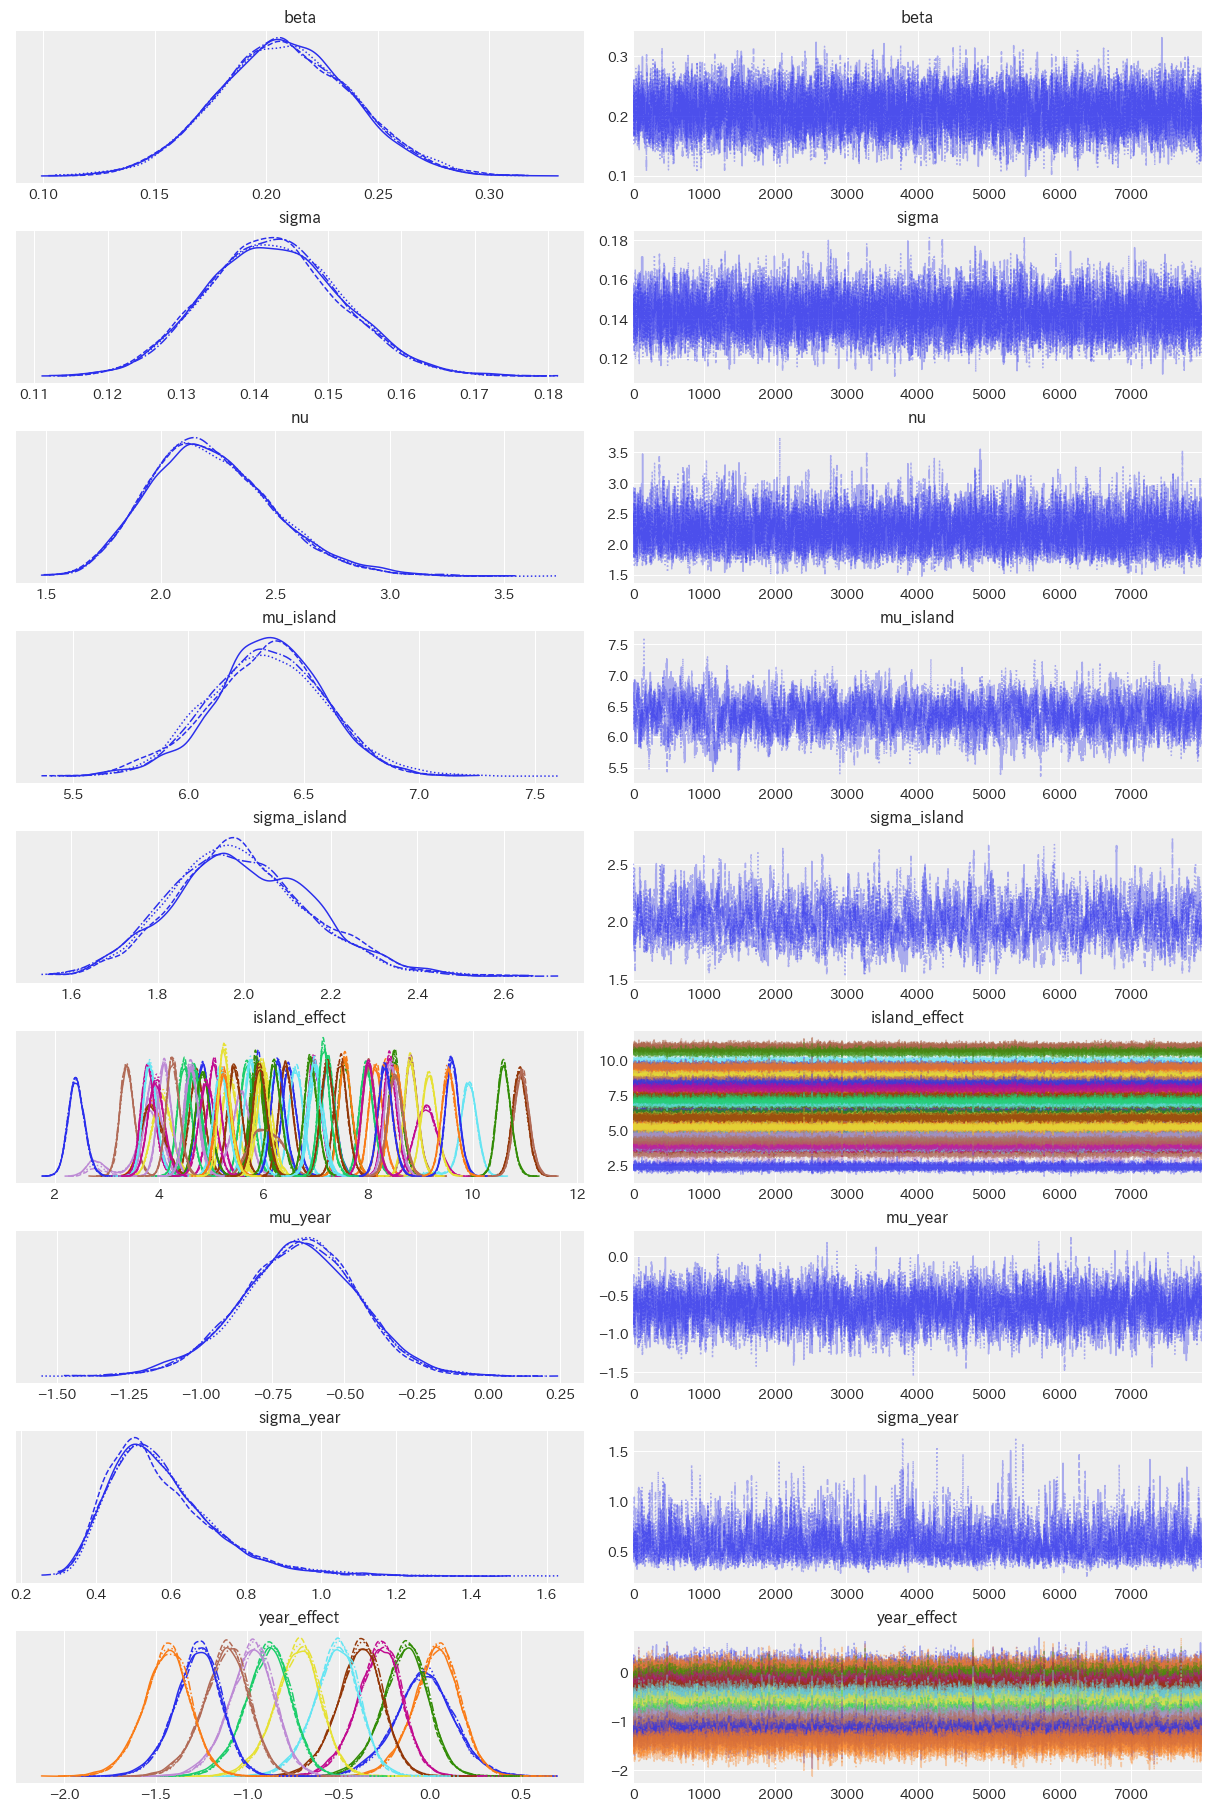

In [ ]:
az.plot_trace(trace_homo, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island', 'island_effect', 'year_effect']);

In [50]:
with model_h_homo:
    pm.compute_log_likelihood(trace_homo)

Output()

In [51]:
az.waic(trace_homo)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 12000 posterior samples and 816 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -57.80    32.84
p_waic      169.85        -

There has been a warning during the calculation. Please check the results.

## 階層ベイズモデル 島別時間効果

In [80]:
# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年ダミー
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
# 島別タイムトレンド
island_time_trend = dmatrix('C(island_ids):year - 1', df, return_type='dataframe')

COORDS = {'y': df.index, 'X': df.index, 'island_id': mn_island_ids, 'year': year_dummies.columns}

with pm.Model(coords=COORDS) as model_h_homo_time_trend:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    island_ids = pm.Data('island_ids', island_ids, dims='X')
    year = pm.Data('year', df['year'], dims='X')
    treatment = pm.Data('treatment', df['after_treatment'], dims='X')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    mu_year = pm.Normal('mu_year', mu=-0.997, sigma=1)
    sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, dims=('year'))
    year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims=('year'))

    mu_trend = pm.Normal('mu_trend', mu=0, sigma=1)
    sigma_trend = pm.HalfNormal('sigma_trend', sigma=1)
    z_trend = pm.Normal('z_trend', mu=0, sigma=1, dims='island_id')
    trend = pm.Deterministic('trend', mu_trend + sigma_trend * z_trend, dims='island_id')

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)
    sigma = pm.HalfCauchy('sigma', beta=1)

    # expectation
    mu = beta * treatment + island_effect[island_ids] + pm.math.dot(year_dummies, year_effect) + pm.math.dot(island_time_trend, trend)

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop)

In [ ]:
with model_h_homo_time_trend:
    trace_homo_time_trend = pm.sample(
        draws=8000,
        tune=8000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42,
        # target_accept=.99
    )

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

In [86]:
az.summary(trace_homo_time_trend, var_names=['beta', 'mu_island', 'sigma_island', 'sigma', 'nu', 'mu_year', 'sigma_year', 'mu_trend', 'sigma_trend'], hdi_prob=.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta          0.196  0.030     0.137      0.253      0.001    0.001    1008.0   
mu_island     5.167  0.979     3.248      7.131      0.036    0.026     730.0   
sigma_island  0.714  0.228     0.278      1.150      0.069    0.050      11.0   
sigma         0.137  0.009     0.120      0.155      0.000    0.000     764.0   
nu            2.186  0.267     1.694      2.714      0.009    0.007     802.0   
mu_year      -0.798  0.263    -1.328     -0.330      0.083    0.063      10.0   
sigma_year    0.645  0.194     0.348      1.020      0.054    0.039      15.0   
mu_trend      0.001  0.001    -0.000      0.002      0.000    0.000     598.0   
sigma_trend   0.001  0.000     0.001      0.001      0.000    0.000      50.0   

              ess_tail  r_hat  
beta            1943.0   1.00  
mu_island       1560.0   1.00  
sigma_island      25.0   1.27  
sigma           1613.0   1.00  
nu              1503.0   1.00  
mu_year           48.0   1.32  
sigma_year        62.0   1.22  
mu_trend        1443.0   1.01  
sigma_trend       87.0   1.05

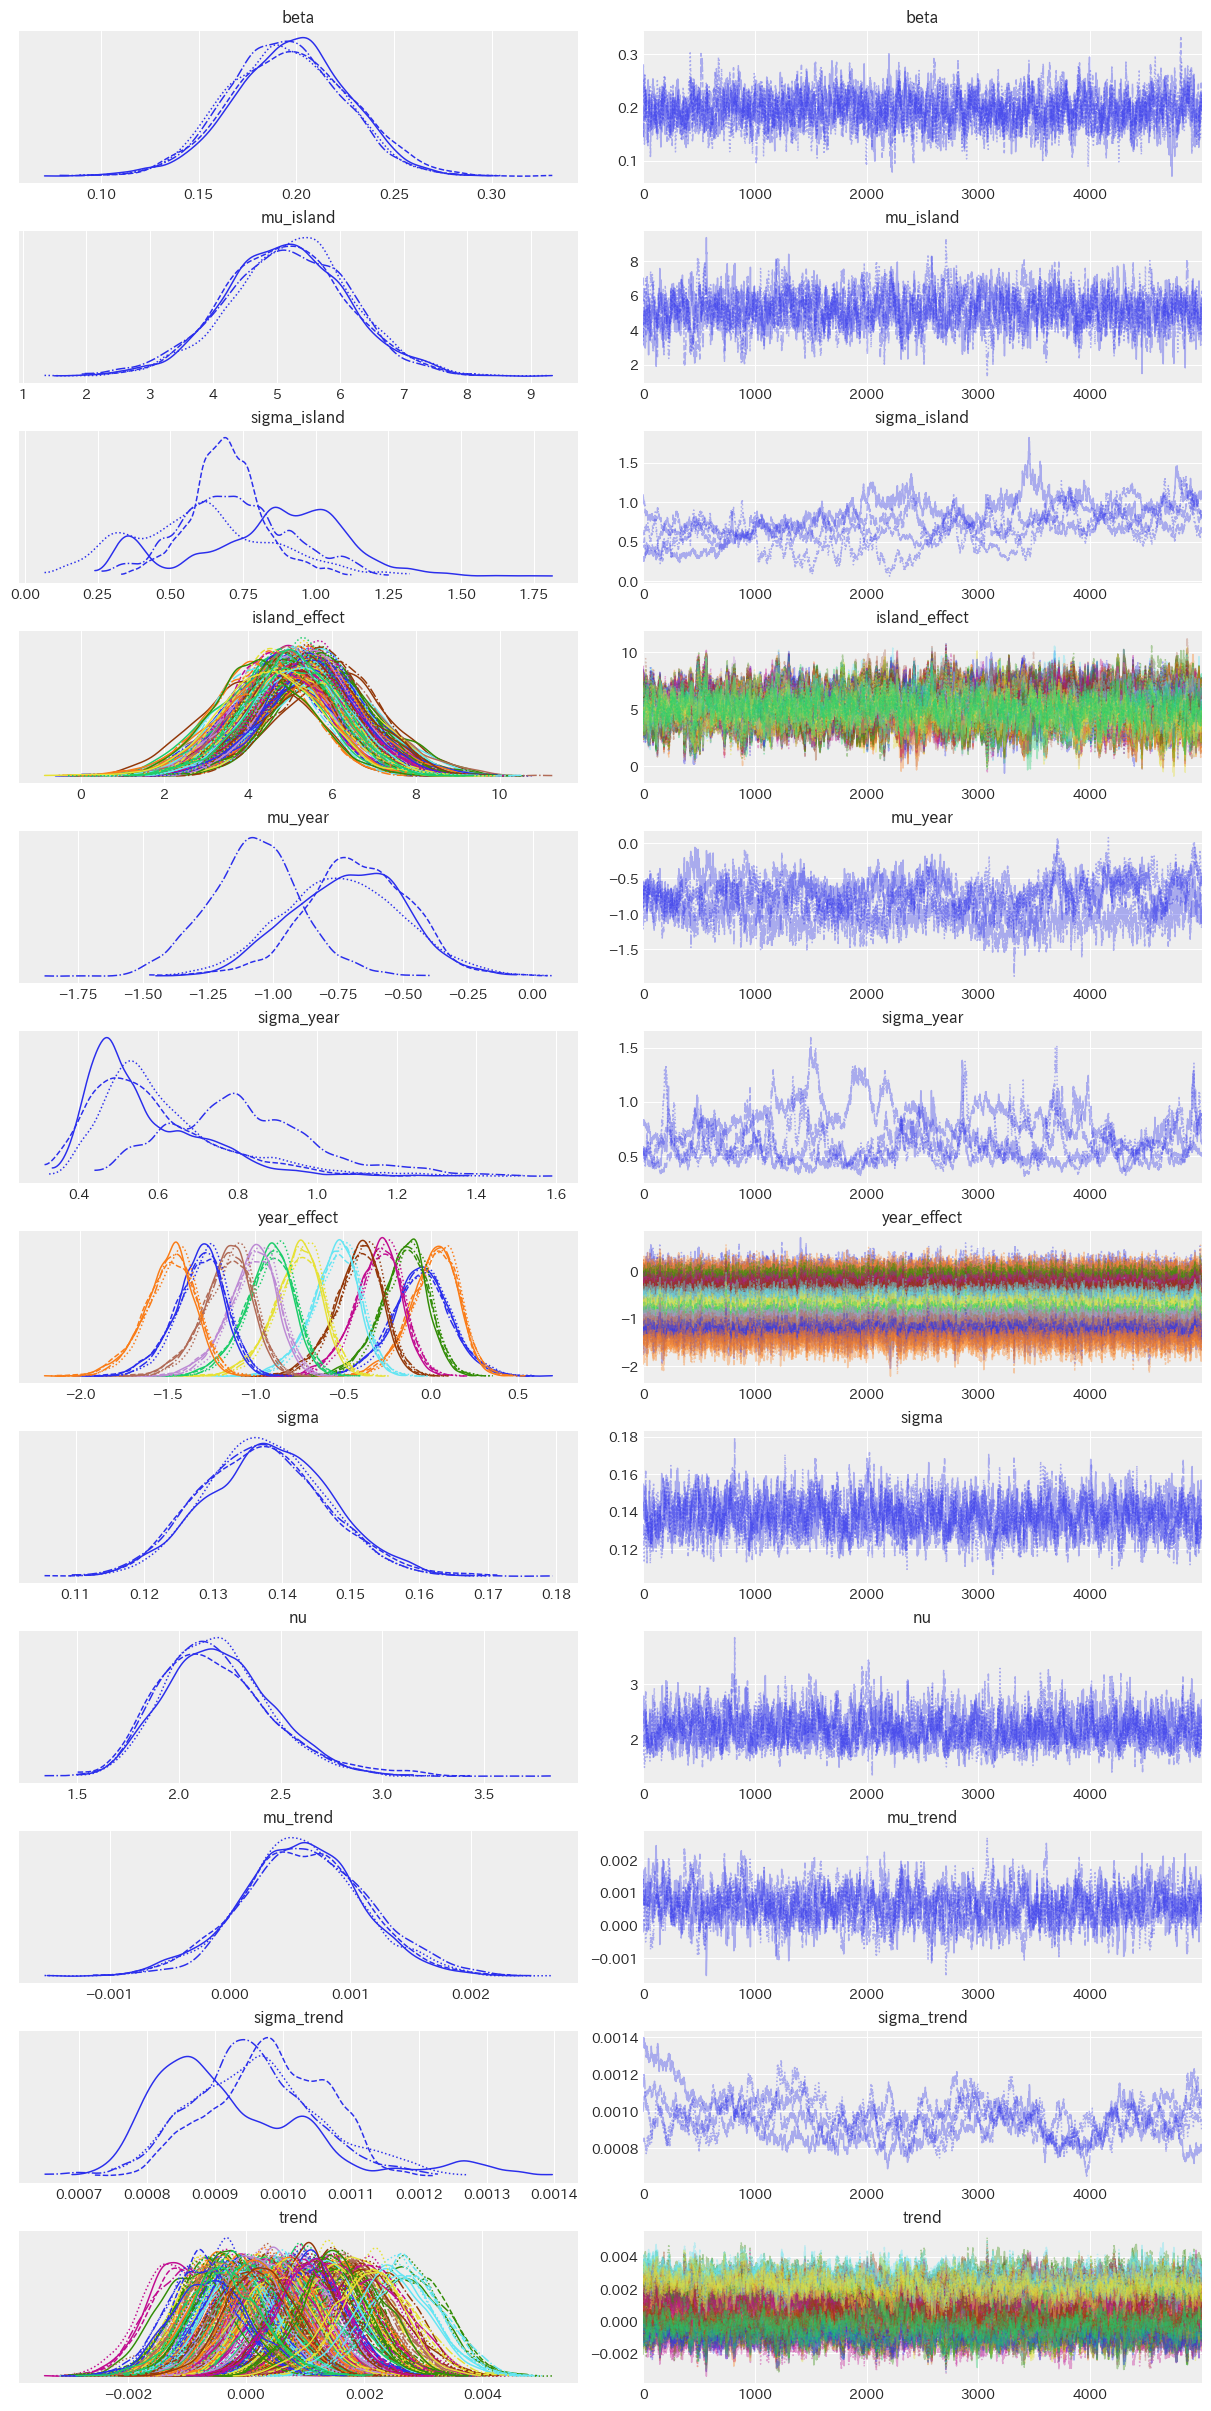

In [87]:
az.plot_trace(trace_homo_time_trend, var_names=['beta', 'mu_island', 'sigma_island', 'island_effect', 'mu_year', 'sigma_year', 'year_effect', 'sigma', 'nu', 'mu_trend', 'sigma_trend', 'trend']);

## 階層ベイズモデル 不均一分散 加重最小2乗法

In [57]:
# 島をカテゴリ化
df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_ids, mn_island_ids = df.island_ids.factorize()
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
COORDS = {'y': df.index, 'X': df.index, 'island_id': mn_island_ids, 'year': year_dummies.columns}

with pm.Model(coords=COORDS) as model_wls:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    island_ids = pm.Data('island_ids', island_ids, dims='X')
    treatment = pm.Data('treatment', df['after_treatment'], dims='X')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=1)
    sigma_island = pm.HalfCauchy('sigma_island', beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    # fixed effects
    beta = pm.Normal('beta', mu=0, sigma=1)
    year_effect = pm.Normal('year_effect', mu=0, sigma=1, dims='year')
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = beta * treatment + island_effect[island_ids] + pm.math.dot(year_dummies, year_effect)

    sigma = pm.HalfCauchy('sigma', 0.15)
    sigma_star = pm.Deterministic('sigma_star', sigma/np.sqrt(log_pop))

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma_star, observed=log_pop, dims='y')

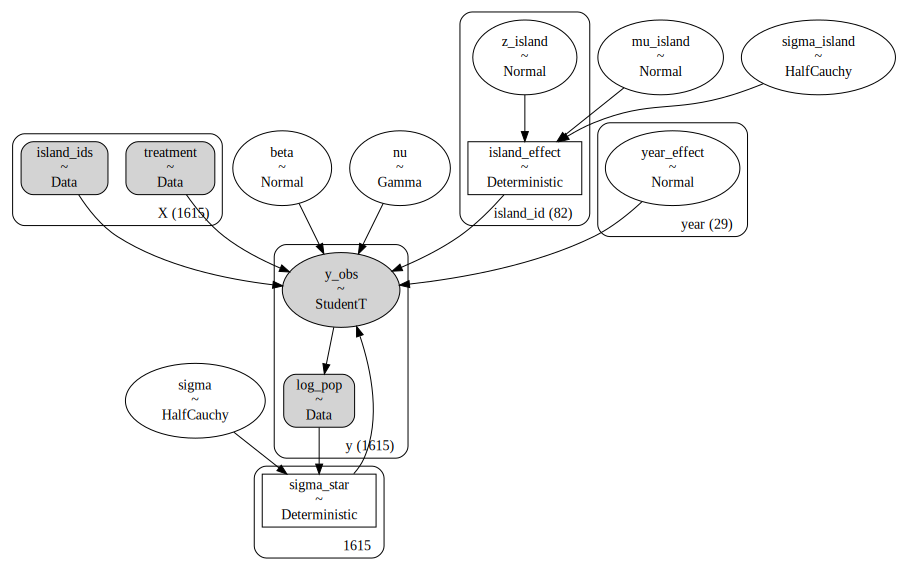

In [58]:
pm.model_to_graphviz(model_wls)

In [59]:
with model_wls:
    trace_wls = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        target_accept=.9,
        nuts_sampler='numpyro'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [60]:
az.to_netcdf(trace_wls, './mcmc_sample/twfe/trace_wls_20250109.nc')

'./mcmc_sample/twfe/trace_wls_20250109.nc'

In [66]:
az.summary(trace_wls, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta          0.111  0.018   0.078    0.146      0.000    0.000    1430.0   
sigma         0.194  0.009   0.178    0.212      0.000    0.000    1431.0   
nu            1.590  0.107   1.396    1.795      0.003    0.002    1473.0   
mu_island     5.155  0.267   4.709    5.722      0.019    0.013     206.0   
sigma_island  2.057  0.158   1.759    2.340      0.010    0.007     262.0   

              ess_tail  r_hat  
beta            1747.0   1.00  
sigma           1892.0   1.00  
nu              1775.0   1.00  
mu_island        292.0   1.01  
sigma_island     508.0   1.02

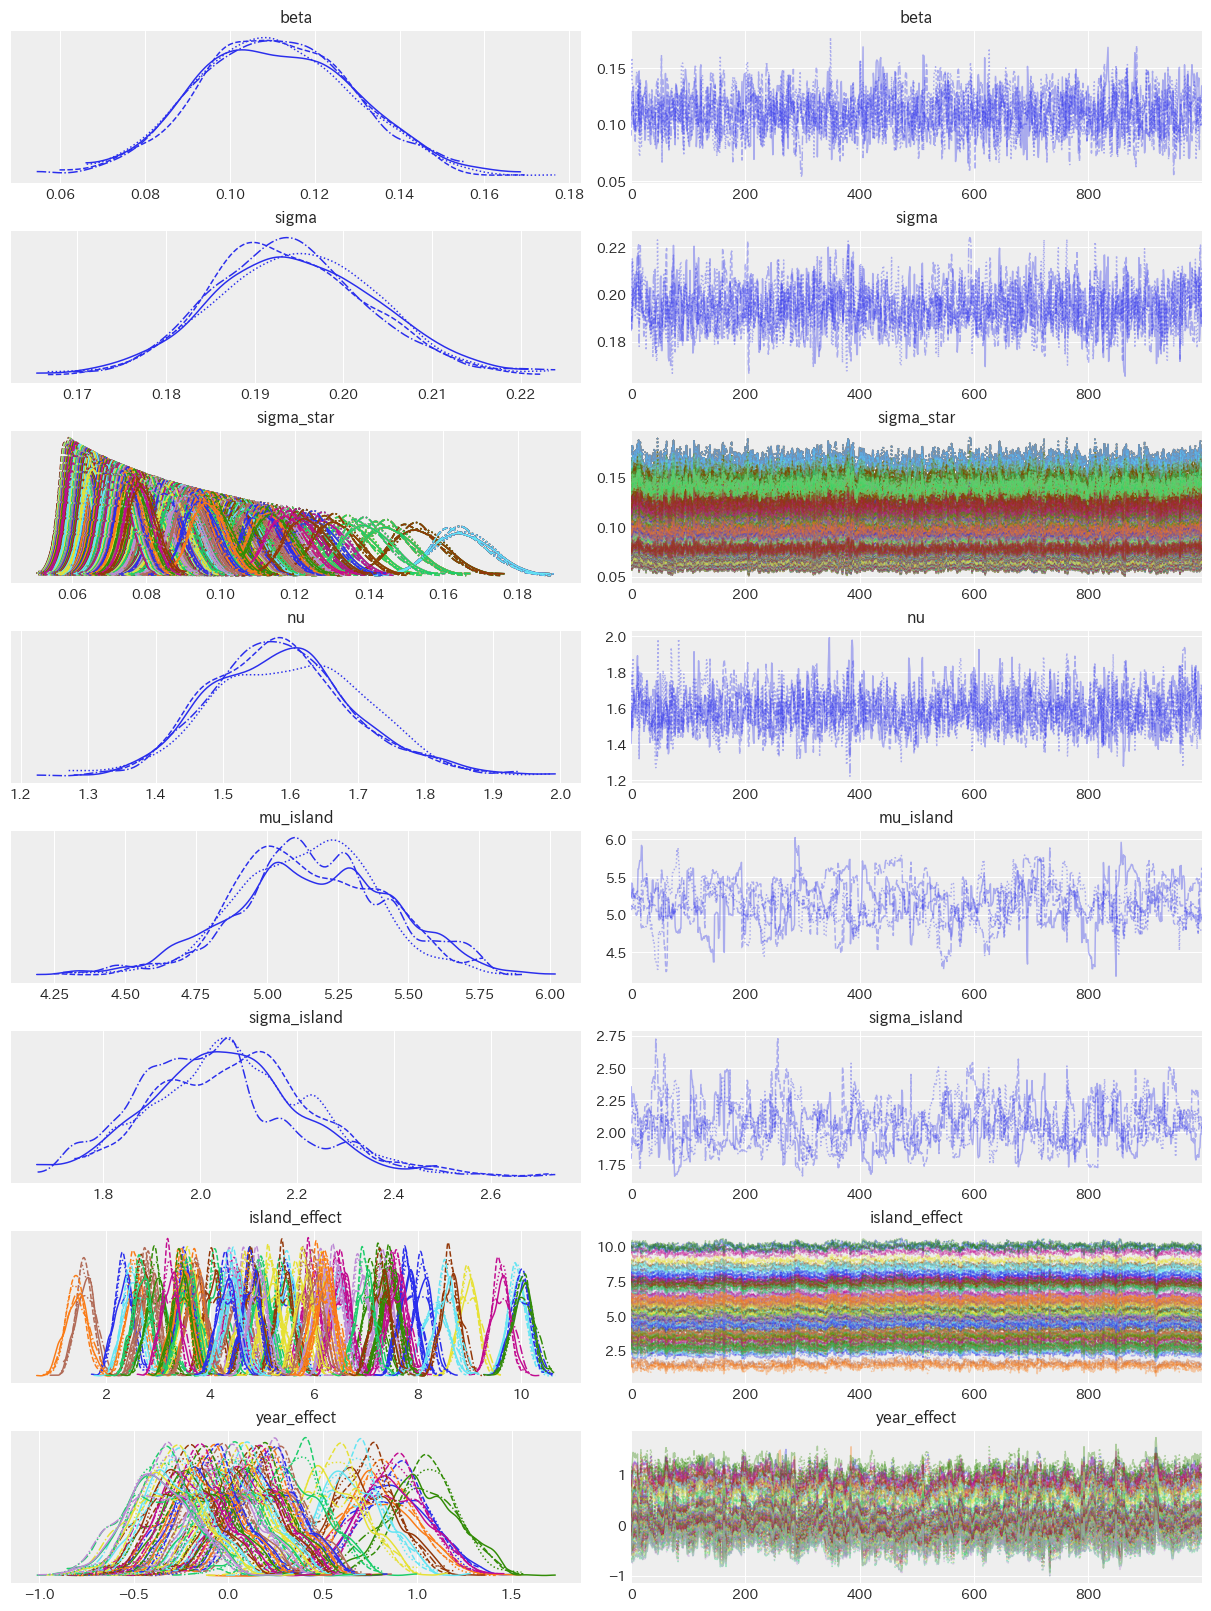

In [65]:
az.plot_trace(trace_wls, var_names=['beta', 'sigma', 'sigma_star', 'nu']);

In [67]:
with model_wls:
    pm.compute_log_likelihood(trace_wls)

Output()

In [68]:
az.waic(trace_wls)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1615 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   396.17    52.41
p_waic      214.98        -

There has been a warning during the calculation. Please check the results.

## 年効果

In [10]:
year_df = az.summary(trace_homo, var_names=['year_effect'], hdi_prob=.95)
pattern = r'year_effect\[C\(year\)\[(\d+)\]\]'
extracted = year_df.index.str.extract(pattern)
extracted.index = year_df.index
year_df['year'] = extracted[0].astype(int)


In [17]:
np.exp(-1.443) - 1

-0.7637819594843863

In [16]:
year_df

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
year_effect[C(year)[1965]] -0.032  0.164    -0.371      0.286      0.001   
year_effect[C(year)[1970]]  0.034  0.129    -0.228      0.282      0.001   
year_effect[C(year)[1975]] -0.137  0.127    -0.396      0.108      0.001   
year_effect[C(year)[1980]] -0.280  0.127    -0.537     -0.035      0.001   
year_effect[C(year)[1985]] -0.385  0.127    -0.643     -0.141      0.001   
year_effect[C(year)[1990]] -0.515  0.128    -0.774     -0.271      0.001   
year_effect[C(year)[1995]] -0.726  0.128    -0.991     -0.485      0.001   
year_effect[C(year)[2000]] -0.888  0.128    -1.155     -0.650      0.001   
year_effect[C(year)[2005]] -0.978  0.129    -1.234     -0.726      0.001   
year_effect[C(year)[2010]] -1.118  0.129    -1.376     -0.867      0.001   
year_effect[C(year)[2015]] -1.272  0.129    -1.538     -1.031      0.001   
year_effect[C(year)[2020]] -1.443  0.131    -1.707     -1.192      0.001   

                            mcse_sd  ess_bulk  ess_tail  r_hat  year  
year_effect[C(year)[1965]]    0.001   15111.0   15874.0    1.0  1965  
year_effect[C(year)[1970]]    0.001   11506.0   12884.0    1.0  1970  
year_effect[C(year)[1975]]    0.001   11272.0   12653.0    1.0  1975  
year_effect[C(year)[1980]]    0.001   10960.0   12353.0    1.0  1980  
year_effect[C(year)[1985]]    0.001   10869.0   12147.0    1.0  1985  
year_effect[C(year)[1990]]    0.001   10843.0   11910.0    1.0  1990  
year_effect[C(year)[1995]]    0.001   10665.0   12008.0    1.0  1995  
year_effect[C(year)[2000]]    0.001   10667.0   12055.0    1.0  2000  
year_effect[C(year)[2005]]    0.001   10637.0   11807.0    1.0  2005  
year_effect[C(year)[2010]]    0.001   10654.0   12172.0    1.0  2010  
year_effect[C(year)[2015]]    0.001   10699.0   12221.0    1.0  2015  
year_effect[C(year)[2020]]    0.001   10772.0   12591.0    1.0  2020

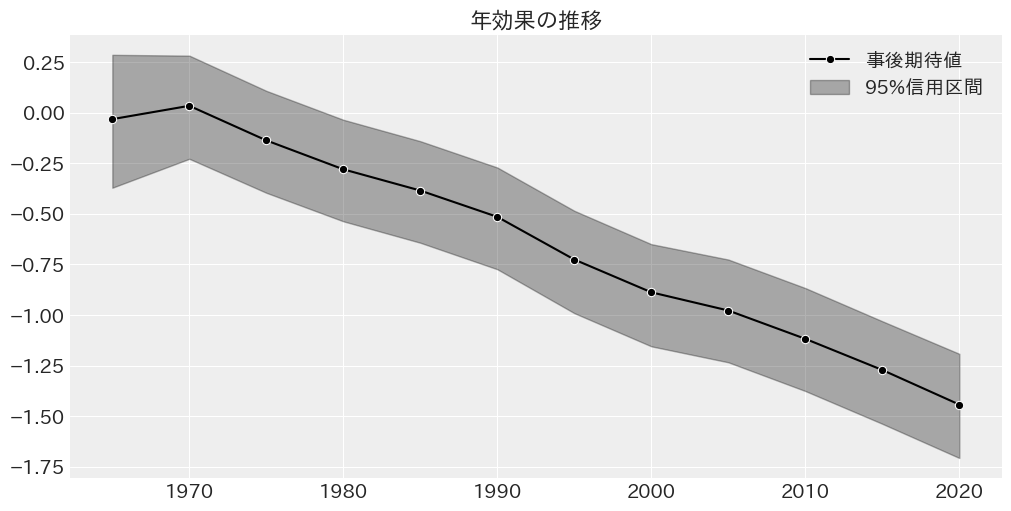

In [12]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x='year', y='mean', data=year_df, ax=ax, marker='o', color='black', label='事後期待値')
ax.fill_between(
    x='year',
    y1='hdi_2.5%',
    y2='hdi_97.5%',
    data=year_df,
    color='black',
    alpha=0.3,
    label='95%信用区間'
)
ax.set_title('年効果の推移')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend()
path = '../../docs/figures/twfe/twfe_year_effects.png'
plt.savefig(path, bbox_inches='tight')

## 島効果

In [39]:
xticks

array([ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78])

IndexError: index 78 is out of bounds for axis 0 with size 78

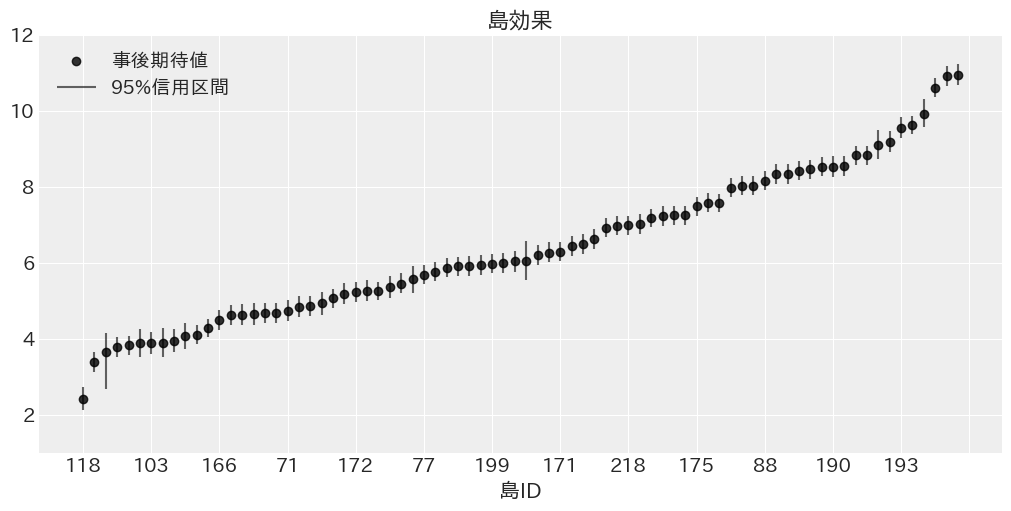

In [15]:
unpooled_means = trace_homo.posterior.mean(dim=('chain', 'draw'))
unpooled_hdi = az.hdi(trace_homo)

unpooled_means_iter = unpooled_means.sortby('island_effect')
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.island_effect)

_, ax = plt.subplots(figsize=figsize)
xticks = np.arange(0, 83, 6)
unpooled_means_iter.plot.scatter(x='island_id', y='island_effect', ax=ax, alpha=0.8, color='black', label='事後期待値')
ax.vlines(
    np.arange(mn_island_ids.size),
    unpooled_hdi_iter.island_effect.sel(hdi='lower'),
    unpooled_hdi_iter.island_effect.sel(hdi='higher'),
    color='black',
    alpha=0.6,
    label='95%信用区間'
)
ax.set_title('島効果')
ax.set(ylabel='', ylim=(1, 12), xlabel='島ID')
ax.legend()
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.island_id.values[xticks])
ax.tick_params(rotation=90)
path = '../../docs/figures/twfe/twfe_island_effect.png'
plt.savefig(path, bbox_inches='tight')